# AAI-540 Group 6 Project
# VenueSignal

# Setup, Configuration, and Connect

In [22]:
!python --version

Python 3.12.9


In [23]:
# Import libraries
import pandas as pd
import numpy as np
import os
import json
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# AWS
import boto3
import sagemaker
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

Libraries imported successfully


In [24]:
#@title Configuration
REGION = "us-east-1"

# Data bucket (read-only public dataset)
DATA_BUCKET = "yelp-aai540-group6"

# Athena bucket (writable, for query results)
ATHENA_BUCKET = "yelp-aai540-group6-athena-297628177412"  # updated for Dean's bucket for this run

# Athena configuration
ATHENA_DB = "yelp"  # Database name created in AthenaTables notebook
ATHENA_RESULTS_S3 = f"s3://{ATHENA_BUCKET}/athena-results/"

print(f"Region: {REGION}")
print(f"Data Bucket: {DATA_BUCKET}")
print(f"Athena Bucket: {ATHENA_BUCKET}")
print(f"Athena Database: {ATHENA_DB}")
print(f"Athena Results Location: {ATHENA_RESULTS_S3}")

Region: us-east-1
Data Bucket: yelp-aai540-group6
Athena Bucket: yelp-aai540-group6-athena-297628177412
Athena Database: yelp
Athena Results Location: s3://yelp-aai540-group6-athena-297628177412/athena-results/


In [25]:
# Create Athena connection
conn = connect(
    s3_staging_dir=ATHENA_RESULTS_S3,
    region_name=REGION,
    cursor_class=PandasCursor
)

print("Connected to Athena")
print(f"  Database: {ATHENA_DB}")
print(f"  Results: {ATHENA_RESULTS_S3}")

Connected to Athena
  Database: yelp
  Results: s3://yelp-aai540-group6-athena-297628177412/athena-results/


In [26]:
#@title List available tables
tables_query = f"SHOW TABLES IN {ATHENA_DB}"
tables_df = pd.read_sql(tables_query, conn)

print(f"Available tables in '{ATHENA_DB}' database:")
display(tables_df)

# Expected tables: business, business_attributes, review, user, checkin, tip

Available tables in 'yelp' database:


,tab_name
0,business
1,business_attributes
2,checkin
3,review
4,tip
5,user


# Load Data

In [27]:
# ALTERNATIVE: Query only businesses that HAVE parking data
business_query_with_parking = f"""
SELECT
    b.business_id,
    b.name,
    b.address,
    b.city,
    b.state,
    b.postal_code,
    b.latitude,
    b.longitude,
    b.stars,
    b.review_count,
    b.is_open,
    b.categories,
    -- Parking features
    ba.parking_garage,
    ba.parking_street,
    ba.parking_validated,
    ba.parking_lot,
    ba.parking_valet,
    -- Additional attributes
    ba.restaurantspricerange2 as price_range,
    ba.restaurantsreservations,
    ba.restaurantstakeout,
    ba.restaurantsdelivery,
    ba.outdoorseating,
    ba.wifi,
    ba.alcohol
FROM {ATHENA_DB}.business b
INNER JOIN {ATHENA_DB}.business_attributes ba
    ON b.business_id = ba.business_id
WHERE b.categories LIKE '%Restaurant%'
  AND b.is_open = 1
  AND b.review_count >= 10
  AND (ba.parking_garage = true 
       OR ba.parking_street = true 
       OR ba.parking_validated = true 
       OR ba.parking_lot = true 
       OR ba.parking_valet = true)
"""

print("Loading restaurants WITH parking data from Athena...")
print("This may take 1-2 minutes...")

df_business = pd.read_sql(business_query_with_parking, conn)

print(f"Loaded {len(df_business):,} restaurants with parking information")
print(f"Dataset shape: {df_business.shape}")

# Verification
print("\n=== PARKING DATA SUMMARY ===")
for col in ['parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet']:
    if col in df_business.columns:
        count = df_business[col].sum()
        print(f"{col}: {count:,} ({count/len(df_business)*100:.1f}%)")

Loading restaurants WITH parking data from Athena...
This may take 1-2 minutes...
Loaded 21,232 restaurants with parking information
Dataset shape: (21232, 24)

=== PARKING DATA SUMMARY ===
parking_garage: 1,319 (6.2%)
parking_street: 7,348 (34.6%)
parking_validated: 331 (1.6%)
parking_lot: 15,497 (73.0%)
parking_valet: 711 (3.3%)


In [28]:
# Basic Data Overview
print("Sample Data:")
display(df_business.head())

print("\nData Types:")
print(df_business.dtypes)

print("\nBasic Statistics:")
display(df_business[['stars', 'review_count', 'latitude', 'longitude']].describe())

Sample Data:


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,parking_validated,parking_lot,parking_valet,price_range,restaurantsreservations,restaurantstakeout,restaurantsdelivery,outdoorseating,wifi,alcohol
0,jZoeTGRfhG9n_Jo6VMqwxw,Sushi Wasabi,5714 111 Street NW,Edmonton,AB,T6H 3G1,53.494577,-113.517946,4.0,57,...,False,True,False,2,True,True,False,False,free,beer_and_wine
1,kGjpBqAqG4mIuFSgU2KKEA,The Royal Indian Cuisine,272 S 20th St,Philadelphia,PA,19103,39.948365,-75.174500,4.0,28,...,False,False,False,NaN,True,True,True,False,no,NaN
2,uKEabBQrn0gLzvTppOrKIA,Casita Taqueria,2701 4th St,Saint Petersburg,FL,33704,27.796976,-82.638168,4.5,207,...,False,True,False,1,False,True,NaN,True,no,beer_and_wine
3,8JEOmVGQffkr6xtn4vvplQ,Pita Kebob,3028 E College Ave,Ruskin,FL,33570,27.713401,-82.394372,4.0,142,...,False,True,False,1,False,NaN,NaN,True,free,NaN
4,rF0xI_3jjlsEKp3N0Z0BuQ,Trattoria Totaro,639 Spring Mill Ave,Conshohocken,PA,19428,40.075052,-75.294523,4.0,135,...,False,False,False,2,True,True,True,True,no,NaN



Data Types:
business_id                 object
name                        object
address                     object
city                        object
state                       object
postal_code                 object
latitude                   float64
longitude                  float64
stars                      float64
review_count                 int64
is_open                      int64
categories                  object
parking_garage              object
parking_street              object
parking_validated           object
parking_lot                 object
parking_valet                 bool
price_range                 object
restaurantsreservations     object
restaurantstakeout          object
restaurantsdelivery         object
outdoorseating              object
wifi                        object
alcohol                     object
dtype: object

Basic Statistics:


,stars,review_count,latitude,longitude
count,21232.000000,21232.000000,21232.000000,21232.000000
mean,3.653989,152.971364,36.833384,-87.972232
std,0.743973,263.568049,5.783311,13.923462
min,1.000000,10.000000,27.564457,-120.083748
25%,3.500000,36.000000,32.207508,-90.231596
50%,4.000000,77.000000,39.438838,-86.070450
75%,4.000000,169.000000,39.956812,-75.353573
max,5.000000,7400.000000,53.649743,-74.699842


## Process Parking Features


In [29]:
# Process Parking Features
print("Processing parking features...")

# The parking columns are object dtype with Python True/False/None values
parking_cols = ['parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet']

for col in parking_cols:
    if col in df_business.columns:
        # Convert Python boolean objects and None to proper pandas boolean
        # True stays True, False stays False, None becomes False
        df_business[col] = df_business[col].map({
            True: True,
            False: False,
            None: False,
            'true': True,   # Just in case
            'True': True,   # Just in case
            'false': False, # Just in case
            'False': False  # Just in case
        }).fillna(False).astype(bool)

# Create convenience columns matching the original notebook naming
df_business['has_garage'] = df_business['parking_garage']
df_business['has_street'] = df_business['parking_street']
df_business['has_validated'] = df_business['parking_validated']
df_business['has_lot'] = df_business['parking_lot']
df_business['has_valet'] = df_business['parking_valet']

# Count how many parking types each restaurant has
df_business['parking_types_count'] = (
    df_business['has_garage'].astype(int) +
    df_business['has_street'].astype(int) +
    df_business['has_validated'].astype(int) +
    df_business['has_lot'].astype(int) +
    df_business['has_valet'].astype(int)
)

# Flag for having any parking
df_business['has_any_parking'] = df_business['parking_types_count'] > 0

print("\n" + "="*60)
print("Parking Features Summary:")
print("="*60)
print(f"Total restaurants: {len(df_business):,}")
print(f"With any parking data: {df_business['has_any_parking'].sum():,} ({df_business['has_any_parking'].mean()*100:.1f}%)")
print(f"\nParking Type Distribution:")
for col in ['has_garage', 'has_street', 'has_validated', 'has_lot', 'has_valet']:
    count = df_business[col].sum()
    pct = count / len(df_business) * 100
    print(f"  {col:20s}: {count:6,} ({pct:5.1f}%)")

print(f"\nParking types count distribution:")
print(df_business['parking_types_count'].value_counts().sort_index())

# Show sample of restaurants with parking
print(f"\nSample restaurants with parking:")
sample_with_parking = df_business[df_business['has_any_parking']][['name', 'city', 'state', 'has_garage', 'has_street', 'has_lot', 'has_valet', 'parking_types_count']].head(10)
display(sample_with_parking)

Processing parking features...

Parking Features Summary:
Total restaurants: 21,232
With any parking data: 21,232 (100.0%)

Parking Type Distribution:
  has_garage          :  1,319 (  6.2%)
  has_street          :  7,348 ( 34.6%)
  has_validated       :    331 (  1.6%)
  has_lot             : 15,497 ( 73.0%)
  has_valet           :    711 (  3.3%)

Parking types count distribution:
parking_types_count
1    17839
2     2938
3      367
4       50
5       38
Name: count, dtype: int64

Sample restaurants with parking:


,name,city,state,has_garage,has_street,has_lot,has_valet,parking_types_count
0,Sushi Wasabi,Edmonton,AB,False,False,True,False,1
1,The Royal Indian Cuisine,Philadelphia,PA,False,True,False,False,1
2,Casita Taqueria,Saint Petersburg,FL,False,False,True,False,1
3,Pita Kebob,Ruskin,FL,False,True,True,False,2
4,Trattoria Totaro,Conshohocken,PA,False,True,False,False,1
5,Katie's Pizza & Pasta Osteria,Town and Country,MO,False,False,True,False,1
6,The Cobblestone Eatery and Drinkery,Lebanon,IL,False,True,False,False,1
7,Kelly's Taproom,Bryn Mawr,PA,False,True,False,False,1
8,Frady's One Stop Food Store,New Orleans,LA,False,True,False,False,1
9,Cantina Los Tres Hombres,Sparks,NV,True,True,True,False,3


In [30]:
# Review Parking Data

print("PARKING FEATURES")
print("=" * 80)

# 1. Columns
print("\n1. COLUMNS IN df_business:")
print("-" * 40)
all_cols = list(df_business.columns)
print(f"Total columns: {len(all_cols)}")
print(f"Columns: {all_cols}\n")

# 2. Check for parking-related columns
print("2. PARKING-RELATED COLUMNS:")
print("-" * 40)
parking_related = [col for col in all_cols if 'parking' in col.lower()]
if parking_related:
    print(f"Found {len(parking_related)} parking columns: {parking_related}")
    for col in parking_related:
        print(f"\n  Column: {col}")
        print(f"    Type: {df_business[col].dtype}")
        print(f"    Non-null: {df_business[col].notna().sum()}")
        print(f"    Null: {df_business[col].isna().sum()}")
        print(f"    Unique values: {df_business[col].unique()[:10]}")  # First 10 unique values
else:
    print("No parking columns found in df_business!")

# 3. Sample of actual data
print("\n3. SAMPLE DATA (first 10 rows, parking columns only):")
print("-" * 40)
if parking_related:
    display(df_business[parking_related].head(10))
else:
    print("No parking columns to display")

# 4. Check business_attributes table directly
print("\n4. QUERYING business_attributes TABLE DIRECTLY:")
print("-" * 40)
try:
    test_query = f"""
    SELECT 
        business_id,
        parking_garage,
        parking_street,
        parking_validated,
        parking_lot,
        parking_valet
    FROM {ATHENA_DB}.business_attributes
    WHERE parking_garage IS NOT NULL 
       OR parking_street IS NOT NULL
       OR parking_validated IS NOT NULL
       OR parking_lot IS NOT NULL
       OR parking_valet IS NOT NULL
    LIMIT 10
    """
    
    test_df = pd.read_sql(test_query, conn)
    print(f"Rows with parking data in business_attributes: {len(test_df)}")
    if len(test_df) > 0:
        print("\nSample from business_attributes table:")
        display(test_df)
    else:
        print("No parking data found in business_attributes table!")
        
except Exception as e:
    print(f"Error querying business_attributes: {e}")

# 5. Check if business_attributes table exists and has data
print("\n5. BUSINESS_ATTRIBUTES TABLE STATS:")
print("-" * 40)
try:
    count_query = f"""
    SELECT 
        COUNT(*) as total_rows,
        COUNT(parking_garage) as garage_count,
        COUNT(parking_street) as street_count,
        COUNT(parking_validated) as validated_count,
        COUNT(parking_lot) as lot_count,
        COUNT(parking_valet) as valet_count
    FROM {ATHENA_DB}.business_attributes
    """
    stats_df = pd.read_sql(count_query, conn)
    print("business_attributes table statistics:")
    display(stats_df)
except Exception as e:
    print(f"Error getting stats: {e}")

# 6. Check JOIN results
print("\n6. JOIN VERIFICATION:")
print("-" * 40)
print(f"df_business rows: {len(df_business)}")
print(f"Rows with business_id: {df_business['business_id'].notna().sum()}")

# Check if the join actually returned parking columns
if parking_related:
    for col in parking_related:
        true_count = (df_business[col] == 'true').sum() if df_business[col].dtype == 'object' else df_business[col].sum()
        false_count = (df_business[col] == 'false').sum() if df_business[col].dtype == 'object' else (~df_business[col]).sum()
        print(f"{col}: True={true_count}, False={false_count}")


PARKING FEATURES

1. COLUMNS IN df_business:
----------------------------------------
Total columns: 31
Columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories', 'parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet', 'price_range', 'restaurantsreservations', 'restaurantstakeout', 'restaurantsdelivery', 'outdoorseating', 'wifi', 'alcohol', 'has_garage', 'has_street', 'has_validated', 'has_lot', 'has_valet', 'parking_types_count', 'has_any_parking']

2. PARKING-RELATED COLUMNS:
----------------------------------------
Found 7 parking columns: ['parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet', 'parking_types_count', 'has_any_parking']

  Column: parking_garage
    Type: bool
    Non-null: 21232
    Null: 0
    Unique values: [False  True]

  Column: parking_street
    Type: bool
    Non-null: 21232
    Null: 0
    Unique valu

,parking_garage,parking_street,parking_validated,parking_lot,parking_valet,parking_types_count,has_any_parking
0,False,False,False,True,False,1,True
1,False,True,False,False,False,1,True
2,False,False,False,True,False,1,True
3,False,True,False,True,False,2,True
4,False,True,False,False,False,1,True
5,False,False,False,True,False,1,True
6,False,True,False,False,False,1,True
7,False,True,False,False,False,1,True
8,False,True,False,False,False,1,True
9,True,True,False,True,False,3,True



4. QUERYING business_attributes TABLE DIRECTLY:
----------------------------------------
Rows with parking data in business_attributes: 10

Sample from business_attributes table:


,business_id,parking_garage,parking_street,parking_validated,parking_lot,parking_valet
0,HCbJPXWXvwN-C7XfmVy3gA,True,True,False,False,False
1,XNBExNkAx5fjYM6fjqfzAA,False,False,False,False,False
2,jZoeTGRfhG9n_Jo6VMqwxw,False,False,False,True,False
3,SBgr-5n-kV3EeZztYsstUQ,False,False,False,True,False
4,O4oK6A5wJuVWpYP4IMgUqw,False,False,False,False,False
5,6XT6OcqGU-8BXKFp7zHoRA,False,False,False,False,False
6,oSp8B87eQ8droCGiWUERZA,False,True,False,True,False
7,kGjpBqAqG4mIuFSgU2KKEA,False,True,False,False,False
8,jKb0H78PubnEMa5JoXdnvw,False,False,False,False,False
9,L9CKPOoI51LNnRW8B1M8CQ,False,False,False,False,False



5. BUSINESS_ATTRIBUTES TABLE STATS:
----------------------------------------
business_attributes table statistics:


,total_rows,garage_count,street_count,validated_count,lot_count,valet_count
0,136602,86885,85474,86654,86516,88795



6. JOIN VERIFICATION:
----------------------------------------
df_business rows: 21232
Rows with business_id: 21232
parking_garage: True=1319, False=19913
parking_street: True=7348, False=13884
parking_validated: True=331, False=20901
parking_lot: True=15497, False=5735
parking_valet: True=711, False=20521
parking_types_count: True=25206, False=-46438
has_any_parking: True=21232, False=0


In [31]:
# RESTAURANT PARKING

print("RESTAURANT PARKING")
print("=" * 80)

# Query 1: Overall restaurant statistics
print("\n1. OVERALL RESTAURANT STATISTICS:")
print("-" * 40)

stats_query = f"""
SELECT 
    COUNT(DISTINCT b.business_id) as total_restaurants,
    COUNT(DISTINCT ba.business_id) as restaurants_with_attributes,
    COUNT(DISTINCT CASE 
        WHEN ba.parking_garage = true 
             OR ba.parking_street = true 
             OR ba.parking_validated = true 
             OR ba.parking_lot = true 
             OR ba.parking_valet = true 
        THEN ba.business_id 
    END) as restaurants_with_parking
FROM {ATHENA_DB}.business b
LEFT JOIN {ATHENA_DB}.business_attributes ba
    ON b.business_id = ba.business_id
WHERE b.categories LIKE '%Restaurant%'
  AND b.is_open = 1
  AND b.review_count >= 10
"""

stats_df = pd.read_sql(stats_query, conn)
print("Restaurant Statistics:")
display(stats_df)

total = stats_df['total_restaurants'].iloc[0]
with_attrs = stats_df['restaurants_with_attributes'].iloc[0]
with_parking = stats_df['restaurants_with_parking'].iloc[0]

print(f"\nPercentages:")
print(f"  Restaurants with attributes: {with_attrs/total*100:.1f}%")
print(f"  Restaurants with parking data: {with_parking/total*100:.1f}%")

# Query 2: Parking type breakdown
print("\n\n2. PARKING TYPE BREAKDOWN:")
print("-" * 40)

parking_breakdown_query = f"""
SELECT 
    SUM(CASE WHEN ba.parking_garage = true THEN 1 ELSE 0 END) as garage_count,
    SUM(CASE WHEN ba.parking_street = true THEN 1 ELSE 0 END) as street_count,
    SUM(CASE WHEN ba.parking_validated = true THEN 1 ELSE 0 END) as validated_count,
    SUM(CASE WHEN ba.parking_lot = true THEN 1 ELSE 0 END) as lot_count,
    SUM(CASE WHEN ba.parking_valet = true THEN 1 ELSE 0 END) as valet_count
FROM {ATHENA_DB}.business b
INNER JOIN {ATHENA_DB}.business_attributes ba
    ON b.business_id = ba.business_id
WHERE b.categories LIKE '%Restaurant%'
  AND b.is_open = 1
  AND b.review_count >= 10
"""

parking_breakdown_df = pd.read_sql(parking_breakdown_query, conn)
print("Parking Type Counts:")
display(parking_breakdown_df)

# Query 3: Sample of restaurants WITH parking
print("\n\n3. SAMPLE RESTAURANTS WITH PARKING DATA:")
print("-" * 40)

sample_with_parking_query = f"""
SELECT 
    b.business_id,
    b.name,
    b.city,
    b.state,
    b.stars,
    b.review_count,
    ba.parking_garage,
    ba.parking_street,
    ba.parking_validated,
    ba.parking_lot,
    ba.parking_valet
FROM {ATHENA_DB}.business b
INNER JOIN {ATHENA_DB}.business_attributes ba
    ON b.business_id = ba.business_id
WHERE b.categories LIKE '%Restaurant%'
  AND b.is_open = 1
  AND b.review_count >= 10
  AND (ba.parking_garage = true 
       OR ba.parking_street = true 
       OR ba.parking_validated = true 
       OR ba.parking_lot = true 
       OR ba.parking_valet = true)
LIMIT 20
"""

sample_with_parking_df = pd.read_sql(sample_with_parking_query, conn)
print(f"Found {len(sample_with_parking_df)} sample restaurants with parking:")
display(sample_with_parking_df)

# Query 4: Sample of restaurants WITHOUT parking in business_attributes
print("\n\n4. SAMPLE RESTAURANTS WITHOUT PARKING DATA:")
print("-" * 40)

sample_without_parking_query = f"""
SELECT 
    b.business_id,
    b.name,
    b.city,
    b.state,
    b.stars,
    b.review_count,
    ba.business_id as has_attributes_record
FROM {ATHENA_DB}.business b
LEFT JOIN {ATHENA_DB}.business_attributes ba
    ON b.business_id = ba.business_id
WHERE b.categories LIKE '%Restaurant%'
  AND b.is_open = 1
  AND b.review_count >= 10
  AND (ba.business_id IS NULL 
       OR (ba.parking_garage IS NULL 
           AND ba.parking_street IS NULL 
           AND ba.parking_validated IS NULL 
           AND ba.parking_lot IS NULL 
           AND ba.parking_valet IS NULL)
       OR (ba.parking_garage = false 
           AND ba.parking_street = false 
           AND ba.parking_validated = false 
           AND ba.parking_lot = false 
           AND ba.parking_valet = false))
LIMIT 20
"""

sample_without_parking_df = pd.read_sql(sample_without_parking_query, conn)
print(f"Found {len(sample_without_parking_df)} sample restaurants without parking:")
display(sample_without_parking_df)

# Query 5: Geographic distribution of parking data
print("\n\n5. GEOGRAPHIC DISTRIBUTION OF PARKING DATA:")
print("-" * 40)

geo_query = f"""
SELECT 
    b.state,
    b.city,
    COUNT(DISTINCT b.business_id) as total_restaurants,
    COUNT(DISTINCT CASE 
        WHEN ba.parking_garage = true 
             OR ba.parking_street = true 
             OR ba.parking_validated = true 
             OR ba.parking_lot = true 
             OR ba.parking_valet = true 
        THEN ba.business_id 
    END) as with_parking
FROM {ATHENA_DB}.business b
LEFT JOIN {ATHENA_DB}.business_attributes ba
    ON b.business_id = ba.business_id
WHERE b.categories LIKE '%Restaurant%'
  AND b.is_open = 1
  AND b.review_count >= 10
GROUP BY b.state, b.city
HAVING COUNT(DISTINCT b.business_id) >= 50
ORDER BY total_restaurants DESC
LIMIT 20
"""

geo_df = pd.read_sql(geo_query, conn)
geo_df['parking_pct'] = (geo_df['with_parking'] / geo_df['total_restaurants'] * 100).round(1)
print("Top cities with parking data coverage:")
display(geo_df)


RESTAURANT PARKING

1. OVERALL RESTAURANT STATISTICS:
----------------------------------------
Restaurant Statistics:


,total_restaurants,restaurants_with_attributes,restaurants_with_parking
0,30445,30313,21232



Percentages:
  Restaurants with attributes: 99.6%
  Restaurants with parking data: 69.7%


2. PARKING TYPE BREAKDOWN:
----------------------------------------
Parking Type Counts:


,garage_count,street_count,validated_count,lot_count,valet_count
0,1319,7348,331,15497,711




3. SAMPLE RESTAURANTS WITH PARKING DATA:
----------------------------------------
Found 20 sample restaurants with parking:


,business_id,name,city,state,stars,review_count,parking_garage,parking_street,parking_validated,parking_lot,parking_valet
0,jZoeTGRfhG9n_Jo6VMqwxw,Sushi Wasabi,Edmonton,AB,4.0,57,False,False,False,True,False
1,kGjpBqAqG4mIuFSgU2KKEA,The Royal Indian Cuisine,Philadelphia,PA,4.0,28,False,True,False,False,False
2,uKEabBQrn0gLzvTppOrKIA,Casita Taqueria,Saint Petersburg,FL,4.5,207,False,None,False,True,False
3,8JEOmVGQffkr6xtn4vvplQ,Pita Kebob,Ruskin,FL,4.0,142,False,True,False,True,False
4,rF0xI_3jjlsEKp3N0Z0BuQ,Trattoria Totaro,Conshohocken,PA,4.0,135,False,True,False,False,False
5,qma1sGQv7ArUtzuUTQElRg,Katie's Pizza & Pasta Osteria,Town and Country,MO,4.0,313,False,False,False,True,False
6,zjQDk4tZyhEroyqtkgvx0g,The Cobblestone Eatery and Drinkery,Lebanon,IL,3.5,52,False,True,False,False,False
7,jsQQu9rVerR3OGxIa0hRQQ,Kelly's Taproom,Bryn Mawr,PA,3.0,63,False,True,False,False,False
8,Hp3Ony7yW60VPuWHQFIIHA,Frady's One Stop Food Store,New Orleans,LA,4.5,73,False,True,False,False,False
9,UX3eq0WsVva-cqlVrzyzFg,Cantina Los Tres Hombres,Sparks,NV,3.0,284,True,True,False,True,False




4. SAMPLE RESTAURANTS WITHOUT PARKING DATA:
----------------------------------------
Found 20 sample restaurants without parking:


,business_id,name,city,state,stars,review_count,has_attributes_record
0,nHUJCK-Ek_lAVTSyEz9GEQ,Adventure Coast Fun Park,Spring Hill,FL,4.5,10,nHUJCK-Ek_lAVTSyEz9GEQ
1,kLSEk3qXY1KdtFjxHJ9pww,McDonald's,Philadelphia,PA,1.5,20,kLSEk3qXY1KdtFjxHJ9pww
2,KsDY9IYqvumohkp74w5i6A,Jersey Mike's Subs,Voorhees,NJ,4.0,21,KsDY9IYqvumohkp74w5i6A
3,wcpL6sD6jKsBO0tbdK2KEA,McDonald's,Fishers,IN,2.0,34,wcpL6sD6jKsBO0tbdK2KEA
4,q2N2KLhAeD0c0p-ryI3uDg,HotBox Pizza,Brownsburg,IN,3.5,14,q2N2KLhAeD0c0p-ryI3uDg
5,q4m9o8LDJRrdU1DcgcAm3w,Auntie Anne's,Clearwater,FL,2.5,10,q4m9o8LDJRrdU1DcgcAm3w
6,RuBWR6CAgVi7iWR8LHUi6A,Lee House,Edmonton,AB,4.0,30,RuBWR6CAgVi7iWR8LHUi6A
7,kq5Ghhh14r-eCxlVmlyd8w,The Coventry Deli,Philadelphia,PA,4.0,65,kq5Ghhh14r-eCxlVmlyd8w
8,7Ct4QuWaY63DkAOXqEiVGA,Hong Kong Chinese Restaurant,Glenolden,PA,3.0,18,7Ct4QuWaY63DkAOXqEiVGA
9,vVm2qH6n4tWzN_qv6PBIVw,The Humming Bird Jerk house,Tampa,FL,3.5,32,vVm2qH6n4tWzN_qv6PBIVw




5. GEOGRAPHIC DISTRIBUTION OF PARKING DATA:
----------------------------------------
Top cities with parking data coverage:


,state,city,total_restaurants,with_parking,parking_pct
0,PA,Philadelphia,3027,2143,70.8
1,FL,Tampa,1727,1187,68.7
2,IN,Indianapolis,1658,1148,69.2
3,TN,Nashville,1497,1086,72.5
4,AZ,Tucson,1476,1009,68.4
5,LA,New Orleans,1262,992,78.6
6,AB,Edmonton,1080,690,63.9
7,MO,Saint Louis,869,665,76.5
8,NV,Reno,755,583,77.2
9,ID,Boise,534,393,73.6


In [32]:
# Convert parking boolean columns (they come as strings 'true'/'false' from Athena)
parking_cols = ['parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet']

#for col in parking_cols:
if col in df_business.columns:
        # Convert string booleans to actual booleans
    df_business[col] = df_business[col].map({
        'true': True,
        'True': True,
        'false': False,
        'False': False,
        None: False
    }).fillna(False)

# Create convenience columns matching the original notebook naming
df_business['has_garage'] = df_business['parking_garage']
df_business['has_street'] = df_business['parking_street']
df_business['has_validated'] = df_business['parking_validated']
df_business['has_lot'] = df_business['parking_lot']
df_business['has_valet'] = df_business['parking_valet']

# Count how many parking types each restaurant has
df_business['parking_types_count'] = (
    df_business['has_garage'].astype(int) +
    df_business['has_street'].astype(int) +
    df_business['has_validated'].astype(int) +
    df_business['has_lot'].astype(int) +
    df_business['has_valet'].astype(int)
)

# Flag for having any parking
df_business['has_any_parking'] = df_business['parking_types_count'] > 0

print("Parking Features Summary:")
print(f"Total restaurants: {len(df_business):,}")
print(f"With any parking data: {df_business['has_any_parking'].sum():,} ({df_business['has_any_parking'].mean()*100:.1f}%)")
print(f"\nParking Type Distribution:")
for col in ['has_garage', 'has_street', 'has_validated', 'has_lot', 'has_valet']:
    count = df_business[col].sum()
    pct = count / len(df_business) * 100
    print(f"  {col:20s}: {count:6,} ({pct:5.1f}%)")

Parking Features Summary:
Total restaurants: 21,232
With any parking data: 21,232 (100.0%)

Parking Type Distribution:
  has_garage          :  1,319 (  6.2%)
  has_street          :  7,348 ( 34.6%)
  has_validated       :    331 (  1.6%)
  has_lot             : 15,497 ( 73.0%)
  has_valet           :    711 (  3.3%)


In [33]:
# Create a filtered dataset with only restaurants that have parking information
df_parking = df_business[df_business['has_any_parking']].copy()

print(f"Filtered dataset with parking info: {len(df_parking):,} restaurants")
print(f"({len(df_parking)/len(df_business)*100:.1f}% of all restaurants)")

Filtered dataset with parking info: 21,232 restaurants
(100.0% of all restaurants)


In [34]:
# Check data load
print("=== Data Loading Diagnostics ===\n")
print(f"df_business shape: {df_business.shape}")
print(f"df_business columns: {list(df_business.columns)}\n")

print("Parking column check:")
for col in ['parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet']:
    if col in df_business.columns:
        print(f" {col}: {df_business[col].notna().sum()} non-null values")
    else:
        print(f" {col}: MISSING")

print(f"\nhas_any_parking column exists: {'has_any_parking' in df_business.columns}")
if 'has_any_parking' in df_business.columns:
    print(f"Restaurants with parking: {df_business['has_any_parking'].sum():,}")
    print(f"df_parking shape: {df_parking.shape if 'df_parking' in locals() else 'NOT CREATED'}")
else:
    print("has_any_parking column was not created!")

print("\nSample of first 3 rows:")
display(df_business[['business_id', 'name', 'city', 'state', 'stars']].head(3))

=== Data Loading Diagnostics ===

df_business shape: (21232, 31)
df_business columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories', 'parking_garage', 'parking_street', 'parking_validated', 'parking_lot', 'parking_valet', 'price_range', 'restaurantsreservations', 'restaurantstakeout', 'restaurantsdelivery', 'outdoorseating', 'wifi', 'alcohol', 'has_garage', 'has_street', 'has_validated', 'has_lot', 'has_valet', 'parking_types_count', 'has_any_parking']

Parking column check:
 parking_garage: 21232 non-null values
 parking_street: 21232 non-null values
 parking_validated: 21232 non-null values
 parking_lot: 21232 non-null values
 parking_valet: 21232 non-null values

has_any_parking column exists: True
Restaurants with parking: 21,232
df_parking shape: (21232, 31)

Sample of first 3 rows:


,business_id,name,city,state,stars
0,jZoeTGRfhG9n_Jo6VMqwxw,Sushi Wasabi,Edmonton,AB,4.0
1,kGjpBqAqG4mIuFSgU2KKEA,The Royal Indian Cuisine,Philadelphia,PA,4.0
2,uKEabBQrn0gLzvTppOrKIA,Casita Taqueria,Saint Petersburg,FL,4.5


## Load Sample Reviews

In [35]:
# Get a sample of reviews for our restaurants
# Note: The review table is partitioned by year and stored in parquet format
reviews_query = f"""
SELECT
    review_id,
    user_id,
    business_id,
    stars,
    useful,
    funny,
    cool,
    text,
    date,
    year
FROM {ATHENA_DB}.review
WHERE year >= 2018
  AND business_id IN (
    SELECT business_id
    FROM {ATHENA_DB}.business
    WHERE categories LIKE '%Restaurant%'
    AND is_open = 1
  )
LIMIT 50000
"""

print("Loading sample reviews...")
print("This may take 2-3 minutes...")

df_reviews = pd.read_sql(reviews_query, conn)

print(f"Loaded {len(df_reviews):,} reviews")
print(f"Date range: {df_reviews['date'].min()} to {df_reviews['date'].max()}")

Loading sample reviews...
This may take 2-3 minutes...
Loaded 50,000 reviews
Date range: 2018-01-01 00:06:10 to 2022-01-19 19:48:13


# Exploratory Data Analysis - Business Data

## Geographic Distribution

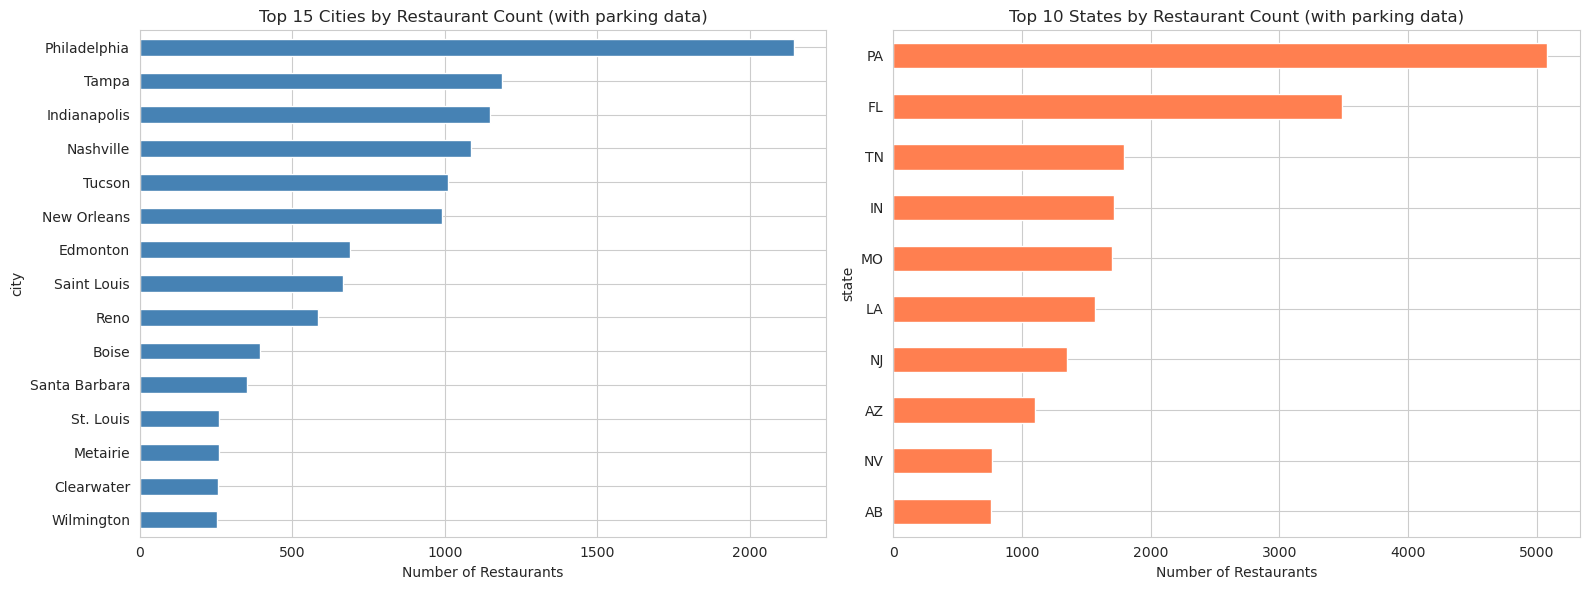


Dataset Statistics:
Total restaurants with parking: 21,232
Total cities: 700
Total states: 14


In [36]:
# Top Cities and States - with data validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Check if we have data
if len(df_parking) == 0:
    print("⚠️ Warning: df_parking is empty. Cannot create visualizations.")
    print(f"Total restaurants in df_business: {len(df_business):,}")
    print(f"Restaurants with parking info: {df_business['has_any_parking'].sum():,}")
else:
    # Cities with most restaurants
    top_cities = df_parking['city'].value_counts().head(15)
    
    if len(top_cities) > 0:
        ax1 = axes[0]
        top_cities.plot(kind='barh', ax=ax1, color='steelblue')
        ax1.set_xlabel('Number of Restaurants')
        ax1.set_title('Top 15 Cities by Restaurant Count (with parking data)')
        ax1.invert_yaxis()
    else:
        axes[0].text(0.5, 0.5, 'No city data available', 
                     ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Top 15 Cities (No Data)')
    
    # Top states
    top_states = df_parking['state'].value_counts().head(10)
    
    if len(top_states) > 0:
        ax2 = axes[1]
        top_states.plot(kind='barh', ax=ax2, color='coral')
        ax2.set_xlabel('Number of Restaurants')
        ax2.set_title('Top 10 States by Restaurant Count (with parking data)')
        ax2.invert_yaxis()
    else:
        axes[1].text(0.5, 0.5, 'No state data available',
                     ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Top 10 States (No Data)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDataset Statistics:")
    print(f"Total restaurants with parking: {len(df_parking):,}")
    print(f"Total cities: {df_parking['city'].nunique()}")
    print(f"Total states: {df_parking['state'].nunique()}")

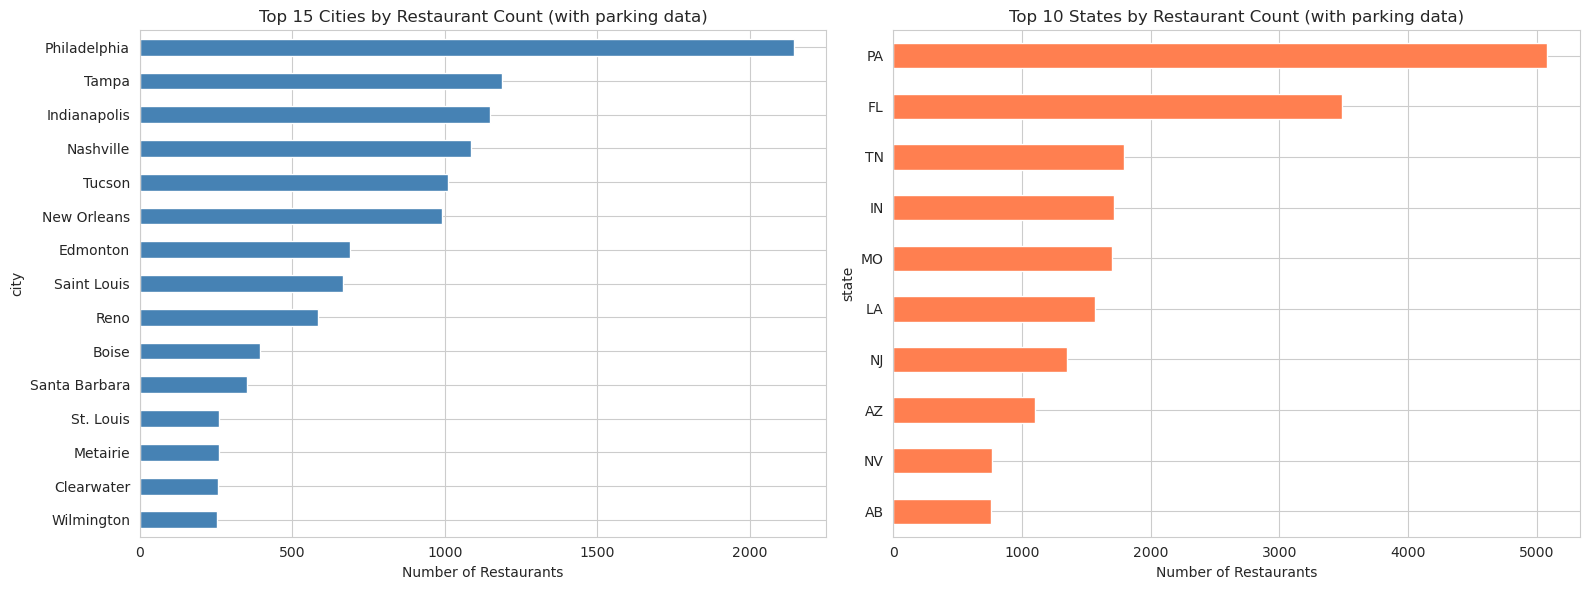

Total cities: 700
Total states: 14


In [37]:
# Top Cities and States
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cities with most restaurants
top_cities = df_parking['city'].value_counts().head(15)
ax1 = axes[0]
top_cities.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Number of Restaurants')
ax1.set_title('Top 15 Cities by Restaurant Count (with parking data)')
ax1.invert_yaxis()

# Top states
top_states = df_parking['state'].value_counts().head(10)
ax2 = axes[1]
top_states.plot(kind='barh', ax=ax2, color='coral')
ax2.set_xlabel('Number of Restaurants')
ax2.set_title('Top 10 States by Restaurant Count (with parking data)')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Total cities: {df_parking['city'].nunique()}")
print(f"Total states: {df_parking['state'].nunique()}")

## Rating Distribution

Rating Statistics:
Mean: 3.65
Median: 4.00
Std Dev: 0.74
Min: 1.0
Max: 5.0


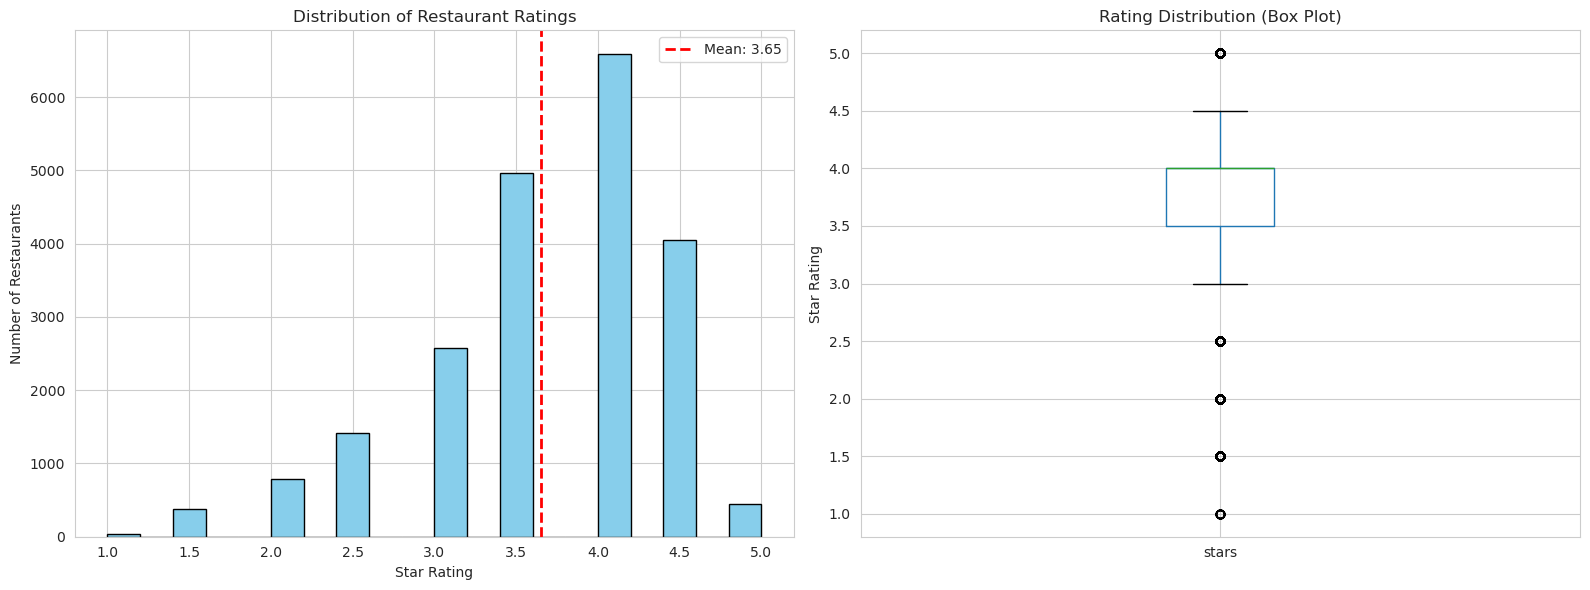

In [38]:
# Rating statistics
print("Rating Statistics:")
print(f"Mean: {df_parking['stars'].mean():.2f}")
print(f"Median: {df_parking['stars'].median():.2f}")
print(f"Std Dev: {df_parking['stars'].std():.2f}")
print(f"Min: {df_parking['stars'].min():.1f}")
print(f"Max: {df_parking['stars'].max():.1f}")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
ax1 = axes[0]
df_parking['stars'].hist(bins=20, ax=ax1, color='skyblue', edgecolor='black')
ax1.axvline(df_parking['stars'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {df_parking["stars"].mean():.2f}')
ax1.set_xlabel('Star Rating')
ax1.set_ylabel('Number of Restaurants')
ax1.set_title('Distribution of Restaurant Ratings')
ax1.legend()

# Box plot
ax2 = axes[1]
df_parking.boxplot(column='stars', ax=ax2)
ax2.set_ylabel('Star Rating')
ax2.set_title('Rating Distribution (Box Plot)')

plt.tight_layout()
plt.show()

## Review Count Distribution

Review Count Statistics:
Mean: 153.0
Median: 77.0
Std Dev: 263.6
Min: 10
Max: 7400


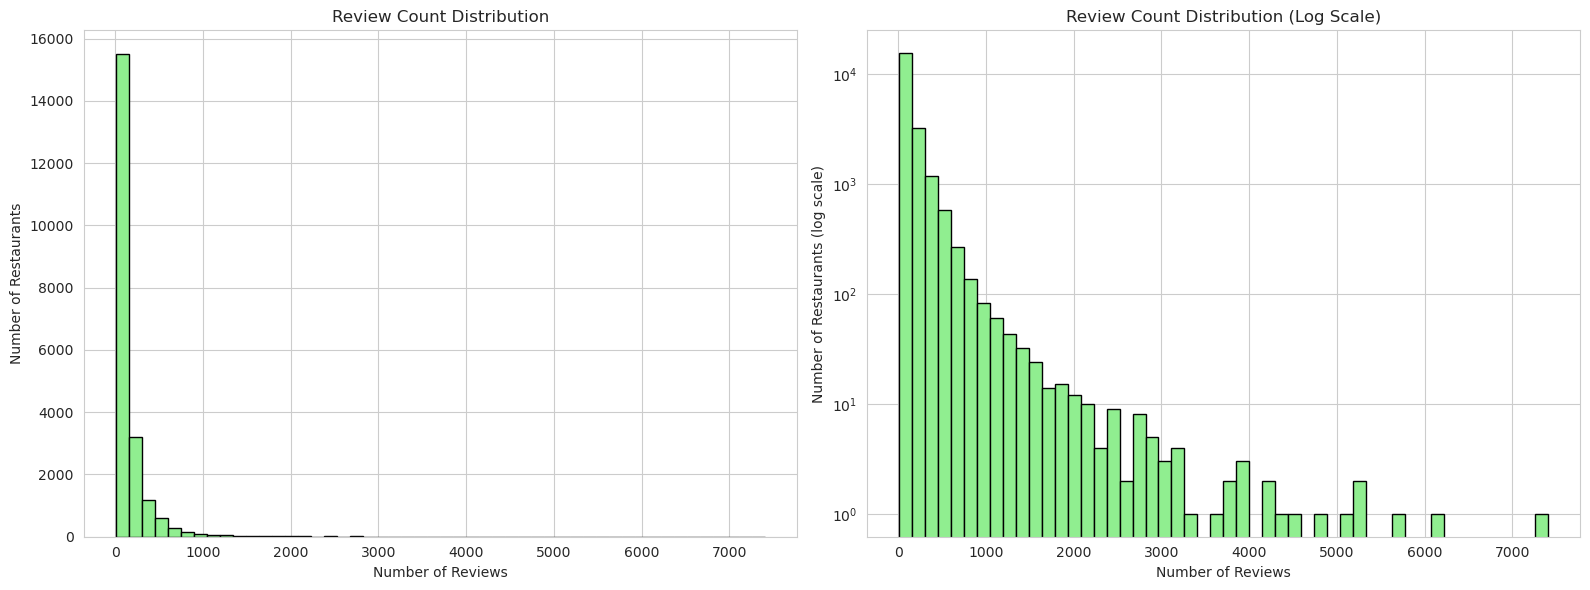

In [39]:
# Review count statistics
print("Review Count Statistics:")
print(f"Mean: {df_parking['review_count'].mean():.1f}")
print(f"Median: {df_parking['review_count'].median():.1f}")
print(f"Std Dev: {df_parking['review_count'].std():.1f}")
print(f"Min: {df_parking['review_count'].min()}")
print(f"Max: {df_parking['review_count'].max()}")

# Plot distribution (log scale)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
df_parking['review_count'].hist(bins=50, ax=ax1, color='lightgreen', edgecolor='black')
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('Number of Restaurants')
ax1.set_title('Review Count Distribution')

ax2 = axes[1]
df_parking['review_count'].hist(bins=50, ax=ax2, color='lightgreen', edgecolor='black', log=True)
ax2.set_xlabel('Number of Reviews')
ax2.set_ylabel('Number of Restaurants (log scale)')
ax2.set_title('Review Count Distribution (Log Scale)')

plt.tight_layout()
plt.show()

## Parking Analysis

Parking Type Availability:


,Parking Type,Count,Percentage
3,Lot,15497,73.0
1,Street,7348,34.6
0,Garage,1319,6.2
4,Valet,711,3.3
2,Validated,331,1.6


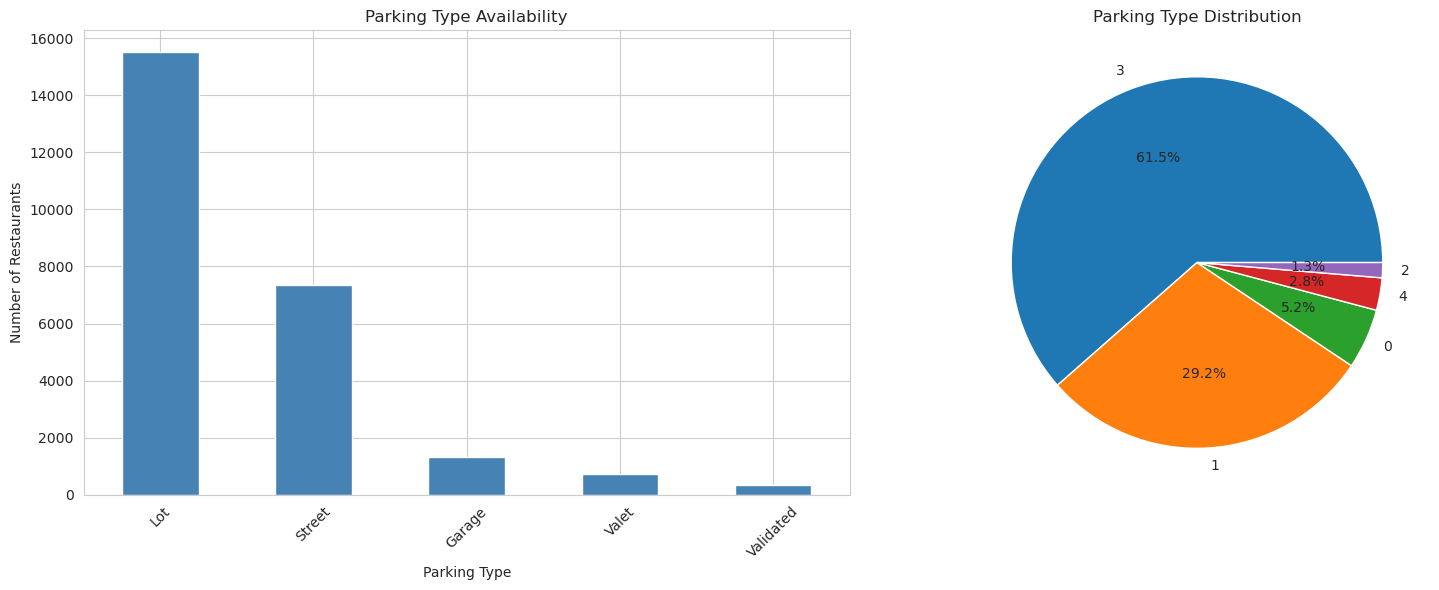

In [40]:
# Parking type distribution
parking_summary = pd.DataFrame({
    'Parking Type': ['Garage', 'Street', 'Validated', 'Lot', 'Valet'],
    'Count': [
        df_parking['has_garage'].sum(),
        df_parking['has_street'].sum(),
        df_parking['has_validated'].sum(),
        df_parking['has_lot'].sum(),
        df_parking['has_valet'].sum()
    ]
})
parking_summary['Percentage'] = (parking_summary['Count'] / len(df_parking) * 100).round(1)
parking_summary = parking_summary.sort_values('Count', ascending=False)

print("Parking Type Availability:")
display(parking_summary)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1 = axes[0]
parking_summary.plot(x='Parking Type', y='Count', kind='bar', ax=ax1, color='steelblue', legend=False)
ax1.set_xlabel('Parking Type')
ax1.set_ylabel('Number of Restaurants')
ax1.set_title('Parking Type Availability')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2 = axes[1]
parking_summary.plot(x='Parking Type', y='Count', kind='pie', ax=ax2, autopct='%1.1f%%',
                     ylabel='', legend=False)
ax2.set_title('Parking Type Distribution')

plt.tight_layout()
plt.show()

Distribution of Number of Parking Types:
  1 type(s): 17,839 restaurants ( 84.0%)
  2 type(s):  2,938 restaurants ( 13.8%)
  3 type(s):    367 restaurants (  1.7%)
  4 type(s):     50 restaurants (  0.2%)
  5 type(s):     38 restaurants (  0.2%)


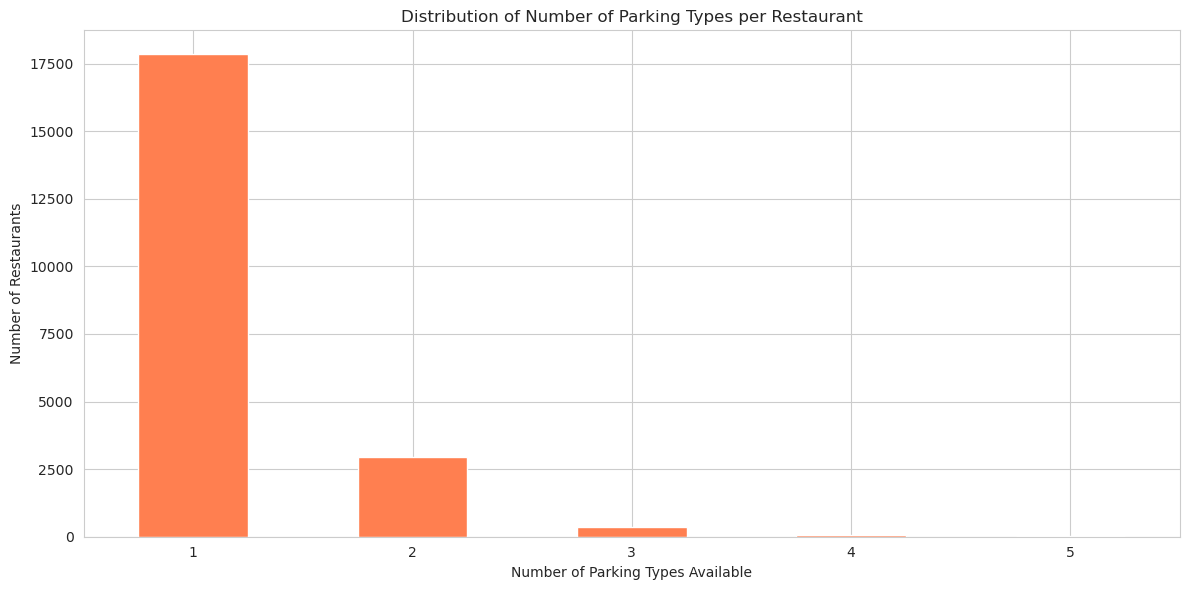

In [41]:
# Number of parking types per restaurant
parking_types_dist = df_parking['parking_types_count'].value_counts().sort_index()

print("Distribution of Number of Parking Types:")
for types, count in parking_types_dist.items():
    pct = count / len(df_parking) * 100
    print(f"  {types} type(s): {count:6,} restaurants ({pct:5.1f}%)")

# Visualize
plt.figure(figsize=(12, 6))
parking_types_dist.plot(kind='bar', color='coral')
plt.xlabel('Number of Parking Types Available')
plt.ylabel('Number of Restaurants')
plt.title('Distribution of Number of Parking Types per Restaurant')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Parking vs Rating Analysis

Average Rating by Parking Type:


,Parking Type,Avg Rating,Count
1,Street,3.930117,7348
0,Garage,3.771039,1319
2,Validated,3.746224,331
4,Valet,3.718706,711
3,Lot,3.561689,15497


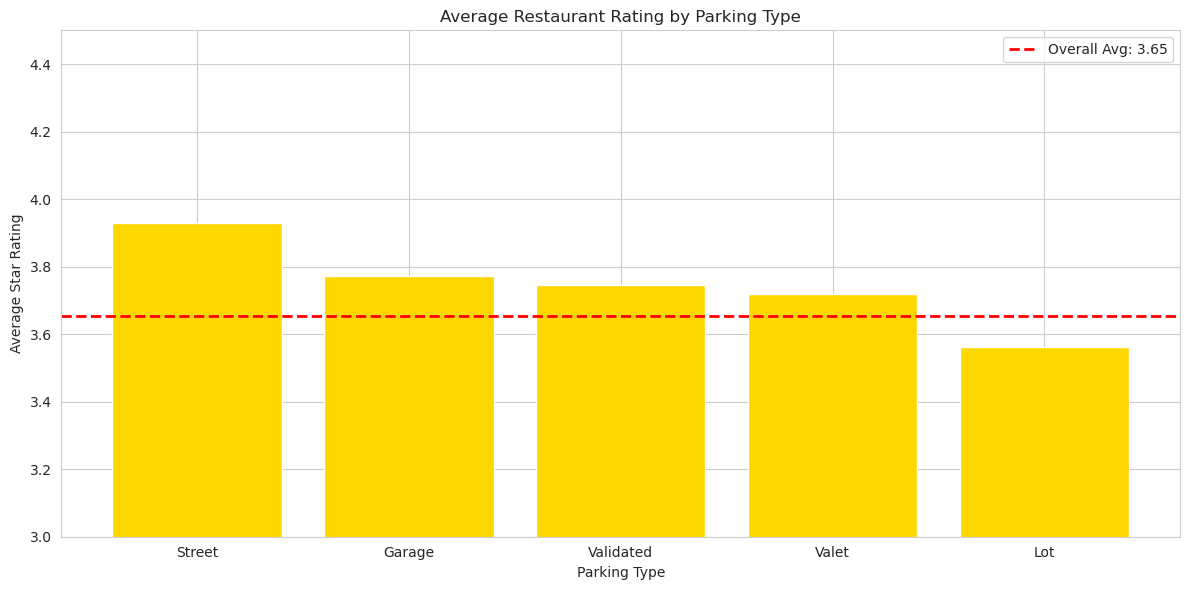

In [42]:
# Compare ratings by parking type
parking_rating_summary = pd.DataFrame({
    'Parking Type': ['Garage', 'Street', 'Validated', 'Lot', 'Valet'],
    'Avg Rating': [
        df_parking[df_parking['has_garage']]['stars'].mean(),
        df_parking[df_parking['has_street']]['stars'].mean(),
        df_parking[df_parking['has_validated']]['stars'].mean(),
        df_parking[df_parking['has_lot']]['stars'].mean(),
        df_parking[df_parking['has_valet']]['stars'].mean()
    ],
    'Count': [
        df_parking['has_garage'].sum(),
        df_parking['has_street'].sum(),
        df_parking['has_validated'].sum(),
        df_parking['has_lot'].sum(),
        df_parking['has_valet'].sum()
    ]
})
parking_rating_summary = parking_rating_summary.sort_values('Avg Rating', ascending=False)

print("Average Rating by Parking Type:")
display(parking_rating_summary)

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(parking_rating_summary['Parking Type'], parking_rating_summary['Avg Rating'], color='gold')
plt.axhline(df_parking['stars'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Overall Avg: {df_parking["stars"].mean():.2f}')
plt.xlabel('Parking Type')
plt.ylabel('Average Star Rating')
plt.title('Average Restaurant Rating by Parking Type')
plt.ylim(3, 4.5)
plt.legend()
plt.tight_layout()
plt.show()

Rating by Number of Parking Types:


,Avg Rating,Restaurant Count
parking_types_count,,
1,3.608246,17839
2,3.914057,2938
3,3.837875,367
4,3.800000,50
5,3.052632,38


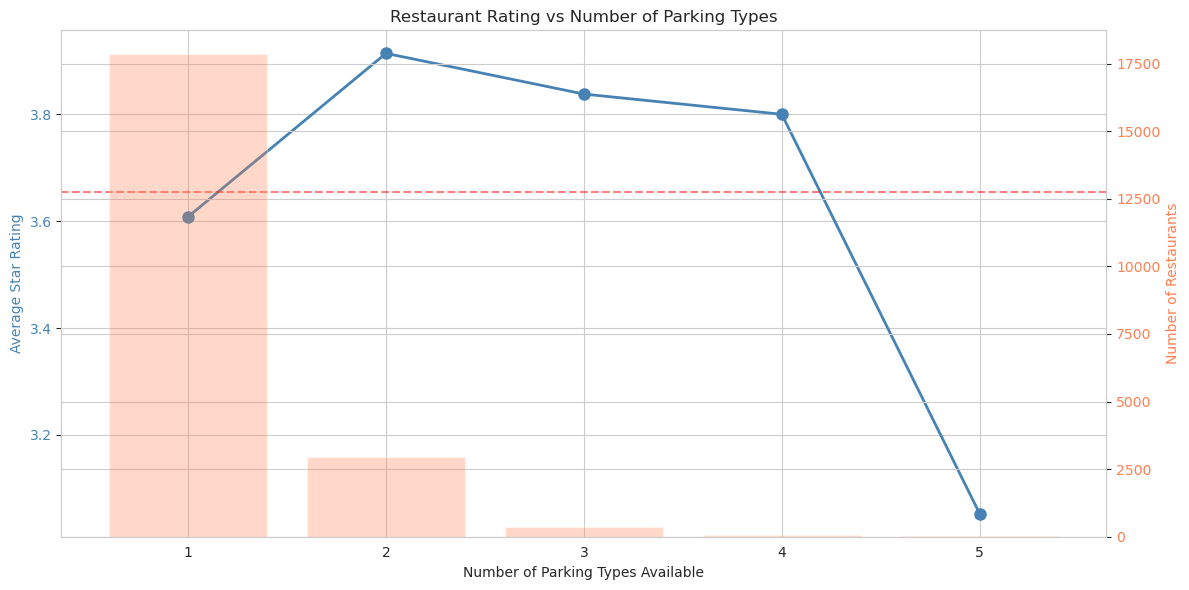

In [43]:
# Rating by number of parking types
rating_by_parking_count = df_parking.groupby('parking_types_count')['stars'].agg(['mean', 'count'])
rating_by_parking_count.columns = ['Avg Rating', 'Restaurant Count']

print("Rating by Number of Parking Types:")
display(rating_by_parking_count)

# Visualize
fig, ax1 = plt.subplots(figsize=(12, 6))

x = rating_by_parking_count.index
ax1.plot(x, rating_by_parking_count['Avg Rating'], 'o-', color='steelblue', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Parking Types Available')
ax1.set_ylabel('Average Star Rating', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.axhline(df_parking['stars'].mean(), color='red', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.bar(x, rating_by_parking_count['Restaurant Count'], alpha=0.3, color='coral')
ax2.set_ylabel('Number of Restaurants', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

plt.title('Restaurant Rating vs Number of Parking Types')
plt.tight_layout()
plt.show()

## City-Level Analysis

Top 15 Cities - Key Statistics:


,Restaurant Count,Avg Rating,Avg Reviews,Avg Parking Types,Valet Count
city,,,,,
Philadelphia,2143,3.742650,213.244517,1.194120,52
Tampa,1187,3.722409,176.447346,1.245156,95
Indianapolis,1148,3.705575,147.652439,1.235192,47
Nashville,1086,3.708103,218.580110,1.338858,109
Tucson,1009,3.560951,167.126858,1.164519,24
New Orleans,992,3.851310,361.893145,1.238911,55
Edmonton,690,3.688406,53.150725,1.214493,8
Saint Louis,665,3.691729,178.666165,1.257143,24
Reno,583,3.638079,241.188679,1.274443,21


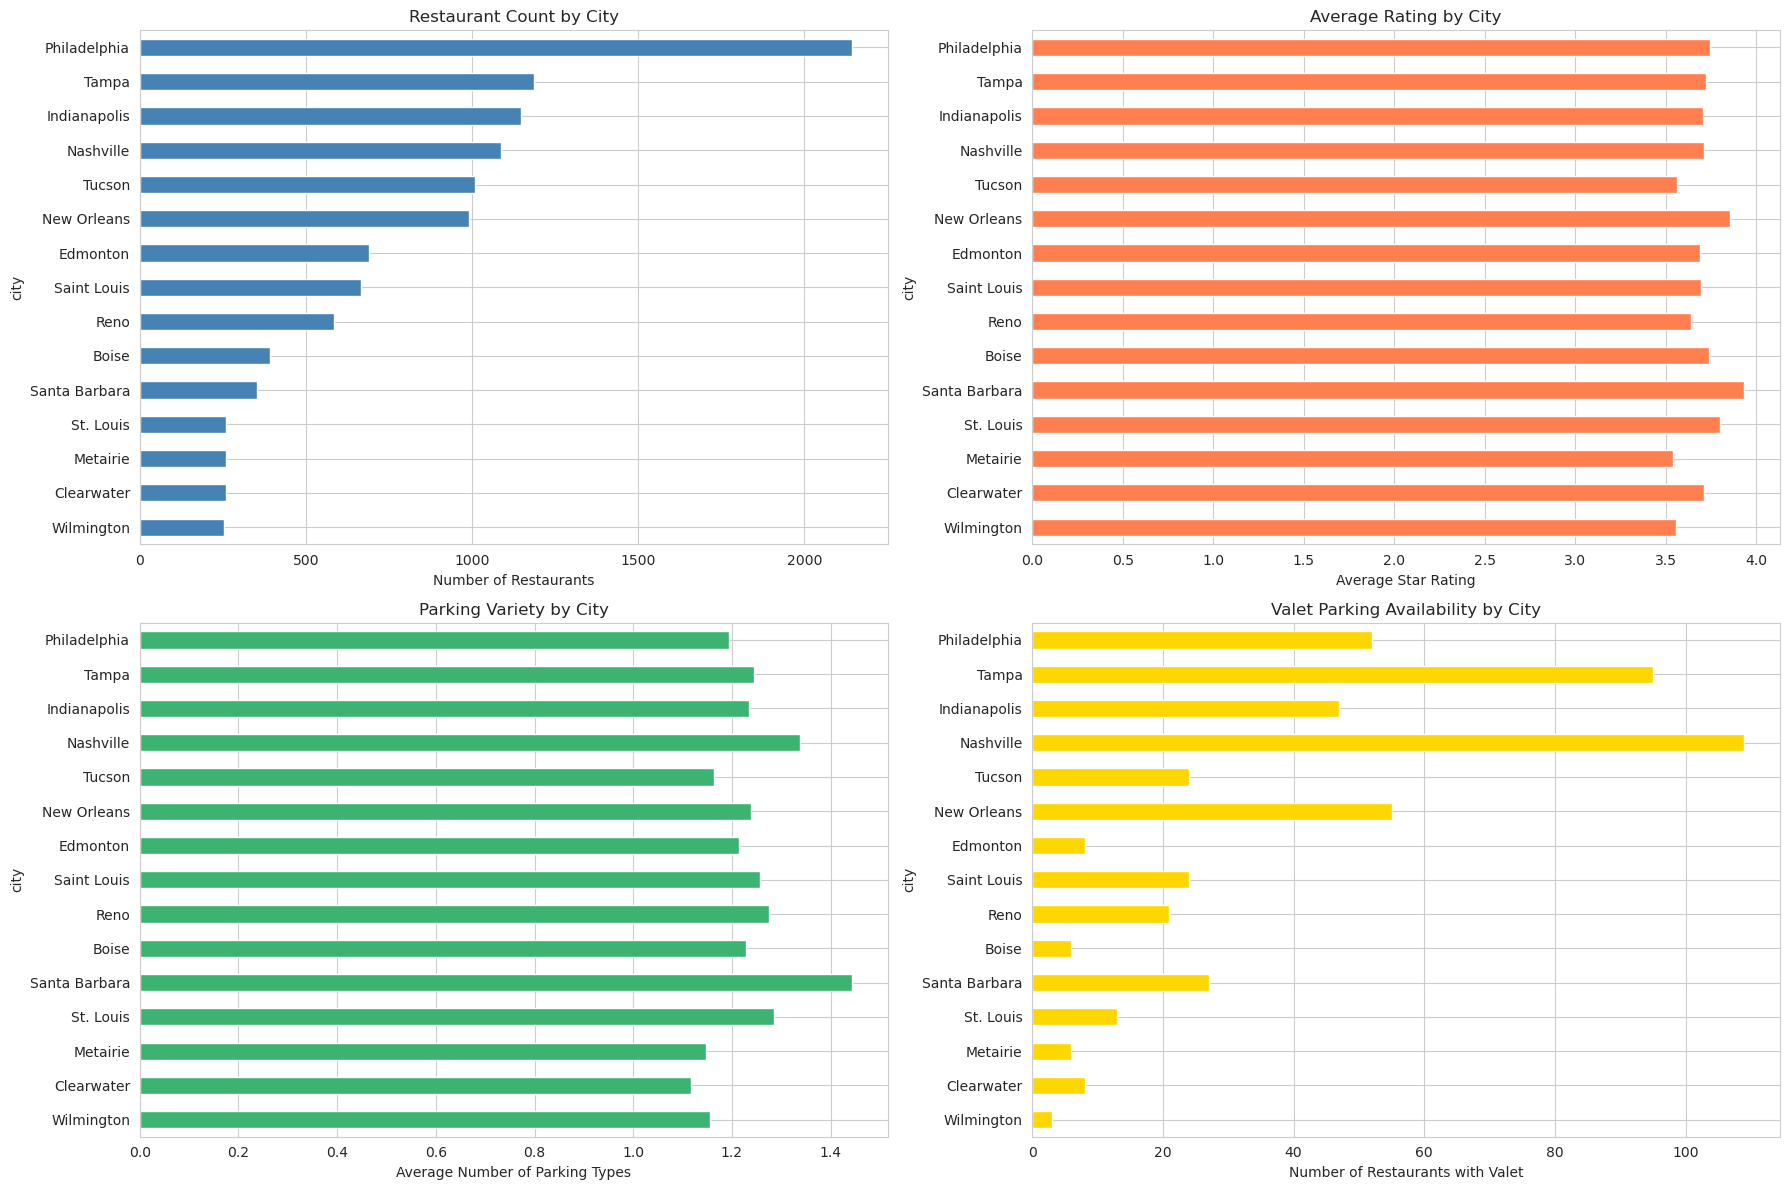

In [44]:
# City-level statistics
city_stats = df_parking.groupby('city').agg({
    'business_id': 'count',
    'stars': 'mean',
    'review_count': 'mean',
    'parking_types_count': 'mean',
    'has_valet': 'sum'
})

city_stats.columns = ['Restaurant Count', 'Avg Rating', 'Avg Reviews', 'Avg Parking Types', 'Valet Count']
city_stats = city_stats.sort_values('Restaurant Count', ascending=False).head(15)

print("Top 15 Cities - Key Statistics:")
display(city_stats)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Restaurant count
city_stats['Restaurant Count'].plot(kind='barh', ax=axes[0,0], color='steelblue')
axes[0,0].set_xlabel('Number of Restaurants')
axes[0,0].set_title('Restaurant Count by City')
axes[0,0].invert_yaxis()

# Average rating
city_stats['Avg Rating'].plot(kind='barh', ax=axes[0,1], color='coral')
axes[0,1].set_xlabel('Average Star Rating')
axes[0,1].set_title('Average Rating by City')
axes[0,1].invert_yaxis()

# Average parking types
city_stats['Avg Parking Types'].plot(kind='barh', ax=axes[1,0], color='mediumseagreen')
axes[1,0].set_xlabel('Average Number of Parking Types')
axes[1,0].set_title('Parking Variety by City')
axes[1,0].invert_yaxis()

# Valet availability
city_stats['Valet Count'].plot(kind='barh', ax=axes[1,1], color='gold')
axes[1,1].set_xlabel('Number of Restaurants with Valet')
axes[1,1].set_title('Valet Parking Availability by City')
axes[1,1].invert_yaxis()

plt.tight_layout()
plt.show()

## Correlation Analysis

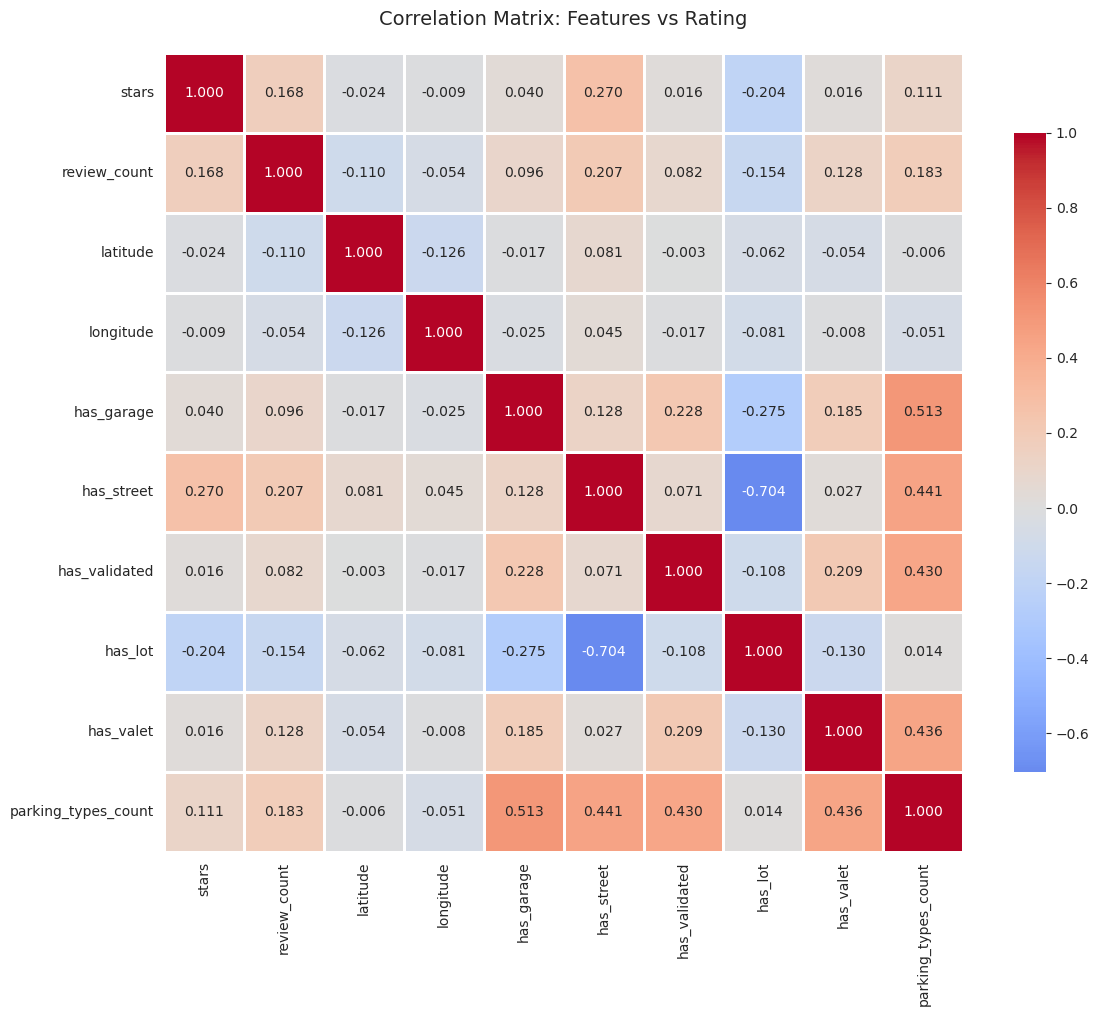


Correlations with Star Rating:
stars                  1.000000
has_street             0.270016
review_count           0.168275
parking_types_count    0.111383
has_garage             0.040493
has_valet              0.016192
has_validated          0.015602
longitude             -0.008730
latitude              -0.023510
has_lot               -0.203944
Name: stars, dtype: float64


In [45]:
# Select numeric columns for correlation
numeric_cols = ['stars', 'review_count', 'latitude', 'longitude',
                'has_garage', 'has_street', 'has_validated', 'has_lot', 'has_valet',
                'parking_types_count']

# Calculate correlation matrix
corr_matrix = df_parking[numeric_cols].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Features vs Rating', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Print correlations with stars
print("\nCorrelations with Star Rating:")
stars_corr = corr_matrix['stars'].sort_values(ascending=False)
print(stars_corr)

# Save Processed Data

In [46]:
# Save cleaned dataset to S3
output_path = f's3://{ATHENA_BUCKET}/processed-data/'

print(f"Saving processed data to S3...")
print(f"Location: {output_path}")

# Save as parquet
df_parking.to_parquet(
    f'{output_path}business_with_parking.parquet',
    index=False,
    compression='snappy'
)

if 'df_reviews' in locals():
    df_reviews.to_parquet(
        f'{output_path}reviews_sample.parquet',
        index=False,
        compression='snappy'
    )

print("\n✓ Data saved successfully!")
print("\nSaved files:")
print(f"  - business_with_parking.parquet ({len(df_parking):,} rows)")
if 'df_reviews' in locals():
    print(f"  - reviews_sample.parquet ({len(df_reviews):,} rows)")
print("\nReady for Feature Engineering!")

Saving processed data to S3...
Location: s3://yelp-aai540-group6-athena-297628177412/processed-data/

✓ Data saved successfully!

Saved files:
  - business_with_parking.parquet (21,232 rows)
  - reviews_sample.parquet (50,000 rows)

Ready for Feature Engineering!
